* 主要参考： https://hrl.boyuai.com/chapter/2/sac%E7%AE%97%E6%B3%95


# Code

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.4 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F
from torch.distributions import Normal

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
import collections
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

##   类模块

### 策略网络 (actor)

连续动作情形，策略网络**输出**一个高斯分布的**均值**和**标准差**来表示动作分布

In [3]:
class PolicyNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound): # # action_bound 是环境可以接受的动作最大值
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)  # 表征动作分布的 高斯分布 的均值
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)  # 表征动作分布的 高斯分布 的标准差
    self.action_bound = action_bound

  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = self.fc_mu(x)
    std = F.softplus(self.fc_std(x))  # 激活函数 f(x) = ln(1+e^x)  # ReLU 的平滑
    dist = Normal(mu, std) # 动作分布
    normal_sample = dist.rsample() # rsample() 重参数化采样
    log_prob = dist.log_prob(normal_sample)
    action = torch.tanh(normal_sample)
    # 计算 tanh_normal 分布的对数概率密度  ？？？
    log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7) # ？？？
    action = action * self.action_bound
    return action, log_prob

https://pytorch.org/docs/stable/_modules/torch/distributions/normal.html#Normal.rsample

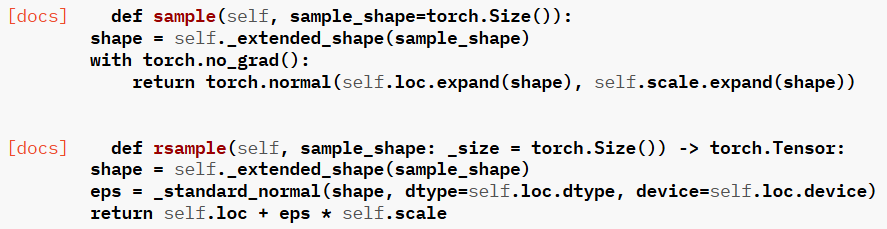

### 价值网络 (critic)

输入： 状态 和 动作 拼接后的向量

输出： 状态-动作 对的价值  Q

In [4]:
class QValueNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim) # 全连接层
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc_out = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1) # 拼接 状态 和 动作
    x = F.relu(self.fc1(cat)) # 隐藏层 使用 ReLU 激活函数
    x = F.relu(self.fc2(x))
    return self.fc_out(x)

### Soft Actor-Critic (SAC) 算法

<font color=red><font size=4>DDPG 中为 actor 也设了一个 目标网络，这也是没用的 trick 吗？</font></font>

In [5]:
class SACContinuous:
  """ 处理连续动作 的 Soft Actor-Critic (SAC) 算法"""
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
    # 策略 网络
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)
    # 价值网络 软 Q 网络 1
    self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    # 价值网络 软 Q 网络 2
    self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    # 两个 软 Q 网络 相应的目标网络
    self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)

    self.target_actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)

    # 初始化 目标网络  和 主网络相同的参数
    self.target_critic_1.load_state_dict(self.critic_1.state_dict())
    self.target_critic_2.load_state_dict(self.critic_2.state_dict())

    self.target_actor.load_state_dict(self.actor.state_dict())

    # 使用 Adam 优化器
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
    self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
    self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)

    # 使用 alpha 的 log 值，可以使训练更稳定  这里的 α： 熵项的权衡系数 用一个网络来学习这个参数
    self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)  # 初始化
    self.log_alpha.requires_grad = True # 可 对 alpha 求梯度
    self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr) # 优化器

    self.target_entropy = target_entropy  # 目标熵 -dim(A)
    self.tau = tau  # 目标网络 软更新的参数
    self.gamma = gamma # 折扣因子
    self.device = device

  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state)[0]
    return [action.item()]

  def calc_target(self, rewards, next_states, dones): # 计算 Q 函数的目标 y = r+γ(1-d)( min(Q1目标,Q2目标)-αlogπ)
    next_actions, log_prob = self.target_actor(next_states)
    entropy = - log_prob
    q1_value = self.target_critic_1(next_states, next_actions)
    q2_value = self.target_critic_2(next_states, next_actions)
    next_values = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy # 转回 α
    y = rewards + self.gamma * (1 - dones) * next_values
    return y

  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)  # τ 远小于 1

  def update(self, transition_dict): # 每回合 更新一次
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device) # view(-1, 1) 数据维度修改为 1 列， 行数自适应
    # ↑ 现在 动作是一个数值，而不是离散的整数，强制 数据类型 为 torch.float
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    # 对倒立摆环境的奖励进行重塑以便训练 ！！！
    rewards = (rewards + 8.0) / 8.0

    # 更新 两个 Q 网络
    y = self.calc_target(rewards, next_states, dones)
    critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), y.detach()))
    self.critic_1_optimizer.zero_grad()
    critic_1_loss.backward()
    self.critic_1_optimizer.step()

    critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), y.detach())) # 定义 loss
    self.critic_2_optimizer.zero_grad() # 梯度重置
    critic_2_loss.backward() # 反向传播
    self.critic_2_optimizer.step() # 更新

    # 更新 策略网络
    new_actions, log_prob = self.actor(states)
    entropy = -log_prob
    q1_value = self.critic_1(states, new_actions) # Q 函数 主网络的值
    q2_value = self.critic_2(states, new_actions)
    actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value)) # 注意 self.log_alpha.exp() 的计算
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # 更新 alpha 值  熵项的权衡系数
    alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
    self.log_alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.log_alpha_optimizer.step()

    # 软更新 目标网络
    self.soft_update(self.critic_1, self.target_critic_1)
    self.soft_update(self.critic_2, self.target_critic_2)

    self.soft_update(self.actor, self.target_actor)

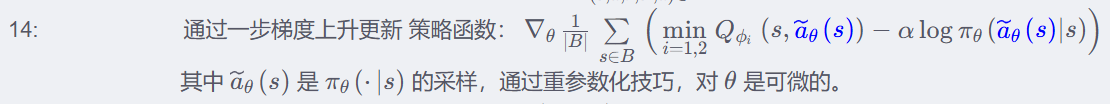

### —— 经验回放

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/pendulum/

In [7]:
# Create and wrap the environment
env_name = "Pendulum-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值
# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0] # 最大动作值


total_num_episodes = 1000  # 回合总数 M
hidden_dim = 128
actor_lr = 3e-4    # 学习率
critic_lr = 3e-3
alpha_lr = 3e-4  # 学习 熵项的权衡系数 α 的网络的学习率
gamma = 0.99       # 折扣因子 γ
tau = 0.005  # 软更新参数 远小于 1
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

rewards_over_seeds = []

for seed in [0, 42, 20, 24, 10]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Reinitialize agent every seed
    agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, \
                          target_entropy, tau, gamma, device)

    replay_buffer = ReplayBuffer(buffer_size) # 创建回放经验池

    reward_over_episodes = []

    # off-policy异策略
    for episode in range(total_num_episodes):
        transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[], 'dones':[]}
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state

            if replay_buffer.size() > minimal_size:
              b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
              transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d }
              agent.update(transition_dict)

        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200

# 运行时长： CPU

Episode: 0 Average Reward: -1172
Episode: 0 Average Reward: -151
Episode: 0 Average Reward: -306
Episode: 0 Average Reward: -212
Episode: 0 Average Reward: -236


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'Soft Actor-Critic (SAC) for Pendulum-v1')]

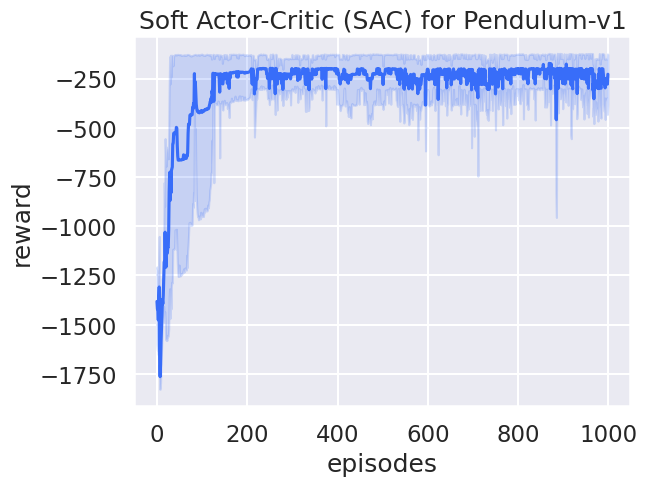

In [8]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="Soft Actor-Critic (SAC) for {}".format(env_name)
)

[Text(0.5, 1.0, 'Soft Actor-Critic (SAC) for Pendulum-v1')]

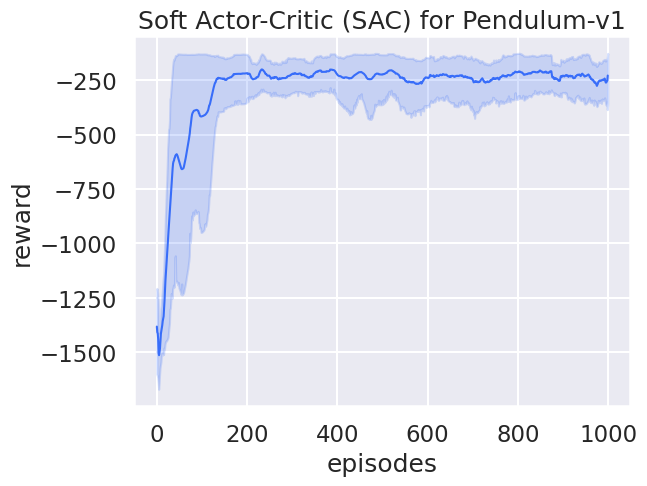

In [9]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="Soft Actor-Critic (SAC) for {}".format(env_name)
)   # 调线宽

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200

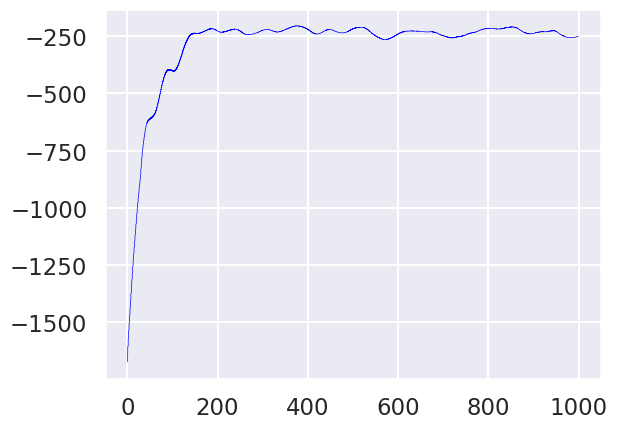

In [10]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

# 将训练结果 存到 本地， 方便后续进行比较 (DataFrame && csv)


https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data

In [11]:
print(YES)   # 无需求则无需运行后续代码

NameError: name 'YES' is not defined

In [12]:
import os
# 查看当前目录
print(os.getcwd())

/content


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Actor-Critics_Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 Actor-Critics_Test

In [14]:
SAC_df = pd.read_csv('/content/drive/MyDrive/Actor-Critics_Test/SAC_Pendulum-v1_1027.csv', index_col=0)   # index_col=0 指定行索引的位置
SAC_df

,SAC_Pendulum-v1
0,-1715.734924
1,-1707.940094
2,-1700.167703
3,-1692.417751
4,-1684.690238
...,...
4995,-241.291297
4996,-241.316692
4997,-241.342283
4998,-241.368068


In [15]:
SAC_df["SAC_Pendulum-v1_with actor target"] = smoothed_y

In [16]:
# SAC_df.to_csv("/content/drive/MyDrive/Actor-Critics_Test/SAC_Pendulum-v1_SAC0.csv")  # 暂存数据
# SAC_df["SAC_Pendulum-v1_with actor target"] = smoothed_y
SAC_df.to_csv("/content/drive/MyDrive/Actor-Critics_Test/SAC_Pendulum-v1_10271214.csv")

In [ ]:
# my_df_loaded = pd.read_csv('/content/drive/MyDrive/Actor-Critics_Test/SAC_Pendulum-v1.csv', index_col=0)   # index_col=0 指定行索引的位置
# my_df_loaded

[Text(0.5, 1.0, 'Comparison of rewards on Pendulum-v1')]

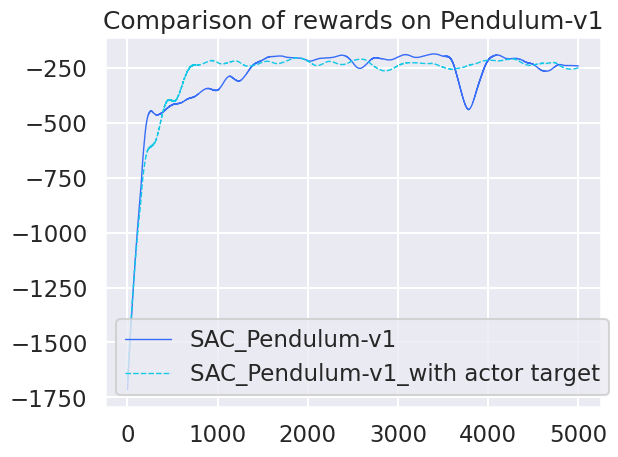

In [17]:
# 绘图比较
 # palette={'DQN':'gray','DDQN':'blue','Dueling DQN':'red'},style_order=['Dueling DQN','DDQN','DQN']
sns.lineplot(data=SAC_df, linewidth=1).set(
    title="Comparison of rewards on {}".format(env_name)
)

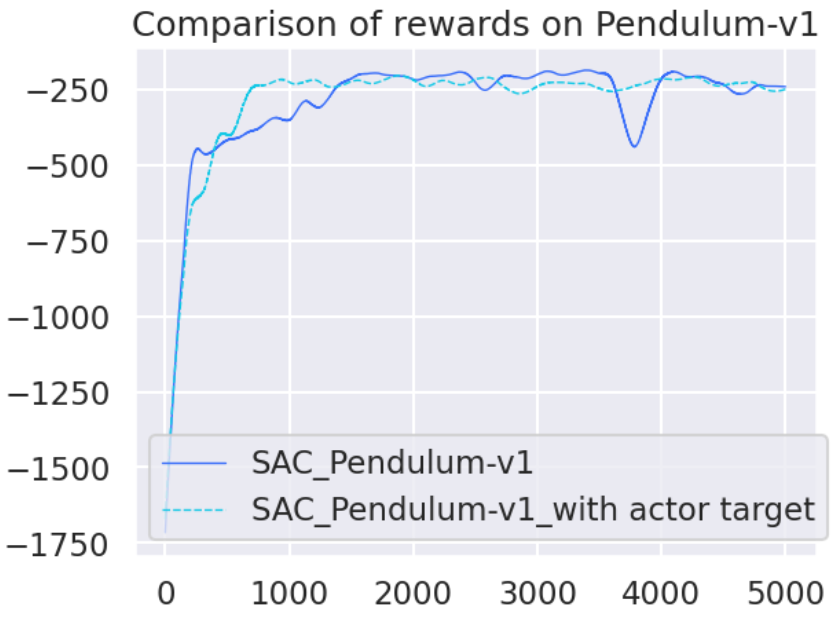

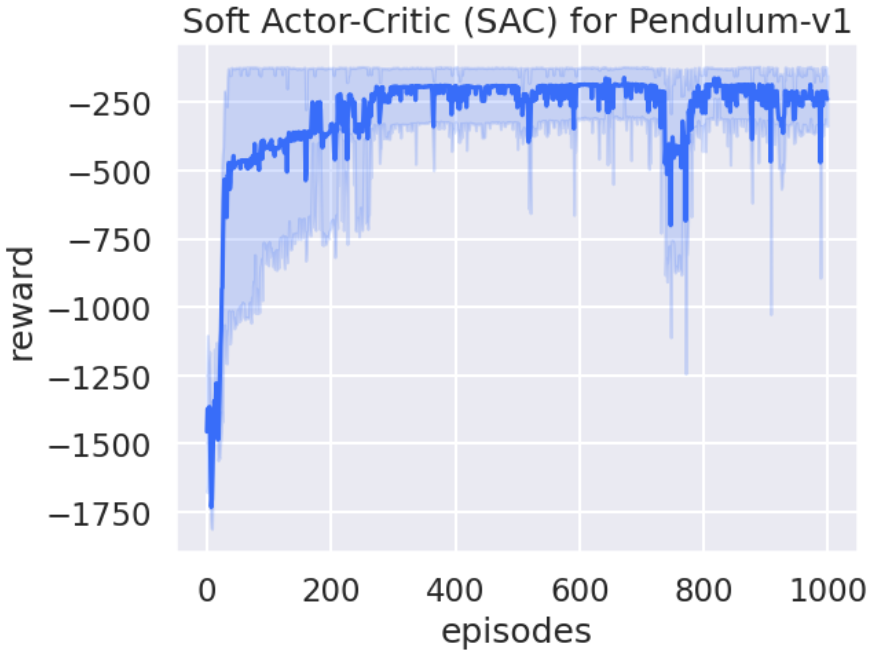

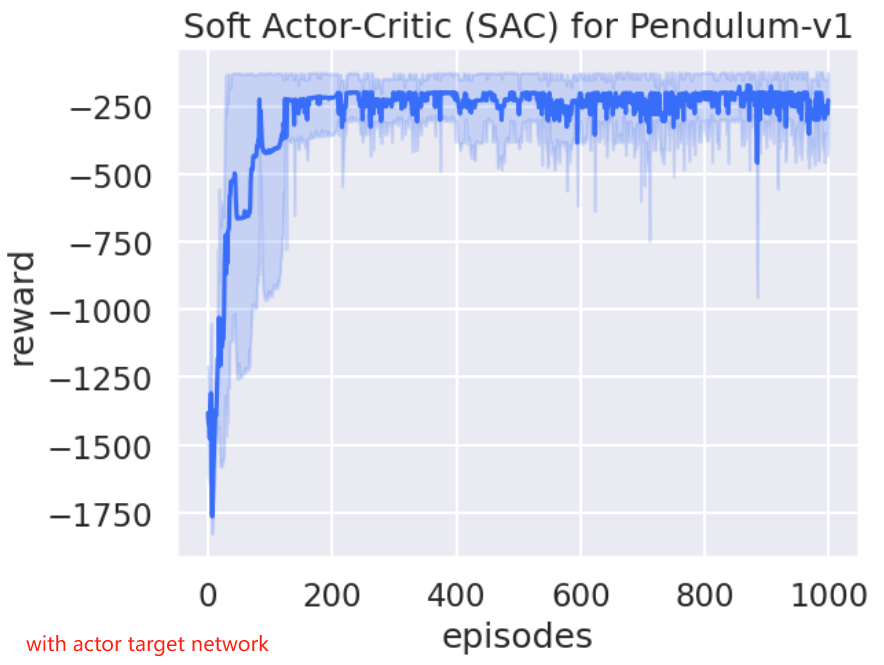

# 保存习得的策略的权重 + 在环境中可视化效果

## 保存/加载 网络权重

In [ ]:
print(YES)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Actor-Critics_Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 Actor-Critics_Test

In [ ]:
# 存储 策略网络权重
actor_weights_path = "/content/drive/MyDrive/Actor-Critics_Test/weights/actor_weights_SAC_Pendulum-v1_2.h5"
critic_1_weights_path = "/content/drive/MyDrive/Actor-Critics_Test/weights/critic_1_weights_SAC_Pendulum-v1_2.h5"
critic_2_weights_path = "/content/drive/MyDrive/Actor-Critics_Test/weights/critic_2_weights_SAC_Pendulum-v1_2.h5"

if not os.path.exists("weights"):
  os.mkdir("weights")

torch.save(agent.actor.state_dict(), actor_weights_path)
torch.save(agent.critic_1.state_dict(), critic_1_weights_path)
torch.save(agent.critic_2.state_dict(), critic_2_weights_path)

In [ ]:
## 加载 网络权重

agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, \
                          target_entropy, tau, gamma, device)

agent.actor.load_state_dict(torch.load(actor_weights_path))
agent.critic_1.load_state_dict(torch.load(critic_1_weights_path))
agent.critic_2.load_state_dict(torch.load(critic_2_weights_path))
agent.actor.eval()
agent.critic_1.eval()
agent.critic_2.eval()

## 策略可视化


In [ ]:
from IPython import display
%matplotlib inline

n_showcase_episodes = 1 # 演示 1 个回合

for episode in range(n_showcase_episodes):
  print(f"starting episode {episode}...")

  env = gym.make("Pendulum-v1", render_mode="rgb_array")

  # 获取初始状态
  state = env.reset()[0]

  img = plt.imshow(env.render()) # only call this once

  done = False
  while not done:
    # 可视化
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    with torch.no_grad():
      action = agent.take_action(state)
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()